In [1]:
# All Imports
import sys 
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import csv
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
#from gensim.test.utils import common_texts

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile


In [2]:
with open('words_dump_train.json','r') as word_dump:
    word_dump = json.load(word_dump)

In [2]:
with open('newInfos.json','r') as tr:
    test_set_genres = json.load(tr)

In [3]:
print(list(test_set_genres.items())[:10])

[('1548880', {'track_id': 1548880, 'track_name': 'What Child Is This?', 'track_name_translation_list': [], 'track_rating': 11, 'commontrack_id': 5608684, 'instrumental': 0, 'explicit': 0, 'has_lyrics': 1, 'has_subtitles': 1, 'has_richsync': 0, 'num_favourite': 0, 'album_id': 10346156, 'album_name': 'Christmas', 'artist_id': 312662, 'artist_name': 'Plus One', 'track_share_url': 'https://www.musixmatch.com/lyrics/Plus-One/What-Child-Is-This?utm_source=application&utm_campaign=api&utm_medium=Freie+Universit%C3%A4t+Berlin%3A1409621343430', 'track_edit_url': 'https://www.musixmatch.com/lyrics/Plus-One/What-Child-Is-This/edit?utm_source=application&utm_campaign=api&utm_medium=Freie+Universit%C3%A4t+Berlin%3A1409621343430', 'restricted': 0, 'updated_time': '2013-06-01T01:24:01Z', 'primary_genres': {'music_genre_list': [{'music_genre': {'music_genre_id': 22, 'music_genre_parent_id': 34, 'music_genre_name': 'Christian & Gospel', 'music_genre_name_extended': 'Christian & Gospel', 'music_genre_va

In [25]:
with open('mxm_dataset_test.txt', 'r') as t_file:
    lines = t_file.readlines()
    words = []
    tracks = {}
    for line in lines:
        if line[0] == 'T':
            cols = line.split(',')
            track = dict(elem.rstrip().split(':', 1) for elem in cols[2:])
            tracks[cols[1]] = track
        elif line[0] == '%':
            line_stripped = line.replace('%','')
            words = line_stripped.split(',')
print(tracks.keys())           
with open('test_documents.json','w') as file:
    json.dump(tracks,file) 

dict_keys(['1548880', '5325944', '3811449', '5583484', '9124657', '4783303', '919759', '2490425', '4097720', '5814195', '1015129', '1856345', '8070067', '6603631', '1380381', '6452870', '2878330', '5383186', '1064466', '743873', '2904033', '1661300', '3738137', '7778487', '2362079', '6392487', '7269607', '4090563', '1191019', '7374957', '1752648', '909659', '7187064', '1391029', '5402570', '3390957', '2933320', '5308605', '7189447', '2943931', '6058437', '1712996', '6707600', '3544125', '5594360', '2630565', '4975679', '818996', '2682843', '6291393', '5282637', '4044299', '1834289', '8852820', '3727733', '3749208', '1832402', '5250477', '7528736', '3483138', '725171', '10043247', '7968920', '2362068', '2563992', '2732896', '6318089', '7106988', '4835503', '2493882', '2064958', '3249320', '791887', '3237719', '8292622', '6065101', '4266281', '739631', '3977183', '6894267', '1027671', '4594649', '7334283', '6064042', '2424134', '3552298', '1682789', '557266', '5459804', '1889276', '42043

In [5]:
with open('test_documents.json','r') as file:
    test_tracks = json.load(file) 

test_sentences = {}

for track in test_tracks.keys():
    test_sentences[track] = []
    for word in test_tracks[track].keys():
        test_sentences[track].append(word_dump[int(word)-1])
zero_lyrics = []
for (k,v) in test_sentences.items():
    if len(v) <1:
        zero_lyrics.append(k)
for x in zero_lyrics:
    test_sentences.pop(x)
print(len(test_sentences))

KeyError: '31216808'

In [51]:
print(len(test_sentences),len(sentences),len(test_set_genres),list(test_set_genres.values())[0])
test_common_ids = dict((k, test_set_genres[k]['commontrack_id']) for k in test_set_genres.keys())
test_track_ids =  dict((k, test_set_genres[k]['track_id']) for k in test_set_genres.keys())
print( len(test_common_ids),len(test_track_ids))

27143 198450 20810 {'track_id': 1548880, 'track_name': 'What Child Is This?', 'track_name_translation_list': [], 'track_rating': 11, 'commontrack_id': 5608684, 'instrumental': 0, 'explicit': 0, 'has_lyrics': 1, 'has_subtitles': 1, 'has_richsync': 0, 'num_favourite': 0, 'album_id': 10346156, 'album_name': 'Christmas', 'artist_id': 312662, 'artist_name': 'Plus One', 'track_share_url': 'https://www.musixmatch.com/lyrics/Plus-One/What-Child-Is-This?utm_source=application&utm_campaign=api&utm_medium=Freie+Universit%C3%A4t+Berlin%3A1409621343430', 'track_edit_url': 'https://www.musixmatch.com/lyrics/Plus-One/What-Child-Is-This/edit?utm_source=application&utm_campaign=api&utm_medium=Freie+Universit%C3%A4t+Berlin%3A1409621343430', 'restricted': 0, 'updated_time': '2013-06-01T01:24:01Z', 'primary_genres': {'music_genre_list': [{'music_genre': {'music_genre_id': 22, 'music_genre_parent_id': 34, 'music_genre_name': 'Christian & Gospel', 'music_genre_name_extended': 'Christian & Gospel', 'music_ge

In [54]:
#print(test_set['3483138'])
not_there = []
no_genre = []
test_documents = []
for track in test_set_genres.keys():
    if len(test_set_genres[track]['primary_genres']['music_genre_list']) > 0:
        genre = test_set_genres[track]['primary_genres']['music_genre_list'][0]['music_genre']['music_genre_id']
        words = []
        if track in test_sentences:
            words = test_sentences[track]
        elif track in sentences:
            words = sentences[track]
        elif test_common_ids[track] in test_sentences:
            words = test_sentences[test_common_ids[track]]
        elif test_common_ids[track] in sentences:
            words = sentences[test_common_ids[track]]
        elif test_track_ids[track] in test_sentences:
            words = test_sentences[test_track_ids[track]]
        elif test_track_ids[track] in sentences:
            words = sentences[test_track_ids[track]]
        else: 
            not_there.append(test_set_genres[track])
        test_documents.append(TaggedDocument(words, [track,genre]))
    else:
        no_genre.append(test_set_genres[track])
print(len(test_documents),len(not_there),len(no_genre))

18702 192 2108


In [55]:
with open('test_documents1.json','w') as file:
    json.dump(test_documents,file) 

In [33]:
with open('tracks_train.json','r') as tracks_file:
    tracks = json.load(tracks_file) 

In [8]:
with open('tracks_annotated.json','r') as tracks_annotated:
    usable_tracks = json.load(tracks_annotated) 

In [12]:

word_counts = {}
for track in usable_tracks:
    for word in track['words'].keys():
        if word in word_counts:
            word_counts[word] += int(track['words'][word])
        else:
            word_counts[word] = int(track['words'][word])
print(len(word_counts))

5000


In [13]:
sentences = {}

for track in usable_tracks:
    if len(track['words'].keys()) < 300:
        sentences[track['id']] = []
        for word in track['words'].keys():
            if word_counts[word] < 170000 or word == '27':
                if word == '27':
                    print(word_dump[int(word)-1])
                sentences[track['id']].append(word_dump[int(word)-1])
zero_lyrics = []
for (k,v) in sentences.items():
    if len(v) <1:
        zero_lyrics.append(k)
for x in zero_lyrics:
    sentences.pop(x)

love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love
love


In [8]:
#with open('sentences.json','w') as f:
#    json.dump(sentences,f) 

with open('sentences.json','r') as f:
    sentences = json.load(f) 

In [34]:
documents = [TaggedDocument(doc, [i]) for (i,doc) in sentences.items()]

In [47]:
#print(len(documents),documents[0][1][0], test_documents[0])
train_documents = []
for i in documents:
    if not (i[1][0] in test_set_genres.keys()):
        train_documents.append(i)
print(len(documents),len(train_documents))

198450 194504


In [48]:
with open('train_documents.json','w') as file:
    json.dump(train_documents,file)

In [21]:
model = Doc2Vec(documents=documents[:40000], vector_size=20, epochs=40, window=5, min_count=2, workers=4)

fname = get_tmpfile("lyrics2vec_model")

model.save(fname)

model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

In [154]:
track_vectors = [model[key] for key in list(sentences.keys())[:5000]]

In [147]:
ranks = []
second_ranks = []
for doc_id in range(20000):
    inferred_vector = model.infer_vector(documents[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector])
    rank = documents[doc_id][1][0] in [i[0] for i in sims]
    ranks.append(rank)
    second_ranks.append(sims[1][0])

In [148]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({True: 4947, False: 53})


In [21]:

def most_similar_track(i):
    inferred_vector = model.infer_vector(documents[i].words)
    sims = model.docvecs.most_similar([inferred_vector])
    print(' '.join(sentences[sims[1][0]]), sims[1][0])
    print('\n')
    tr = next(obj for obj in usable_tracks if obj['id'] == sims[1][0])
    print(tr['title'], tr['artist'] )
    print('\n')
    print(' '.join(documents[i].words), documents[i][1][0])
    print('\n')
    tr = next(obj for obj in usable_tracks if obj['id'] == documents[i][1][0])
    print(tr['title'], tr['artist'] )


most_similar_track(1456)

can oh if got never want take would day babi away yeah heart could night more again onli well turn light call wait ever hey anoth same tear other forev year ooh might miss may ah lone until each near blame number ay guid thrill string mmmm 6670093


No More Lonely Nights Fiona


love when like now come go up they if got from he want make take would ca back here eye caus gonna tell through wanna call were face play thought show pain name same yes open ask hide beauti ai seen hurt under kind game mouth mad guy lock curs explain expect teeth wors wise everytim honest impress compromis disgrac brutal 947532


Otherwise (KCRW Session / Live at Kampo Studios_ NYC 26/7/02) Morcheeba


In [155]:
X = np.array(track_vectors)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(5000, 2)

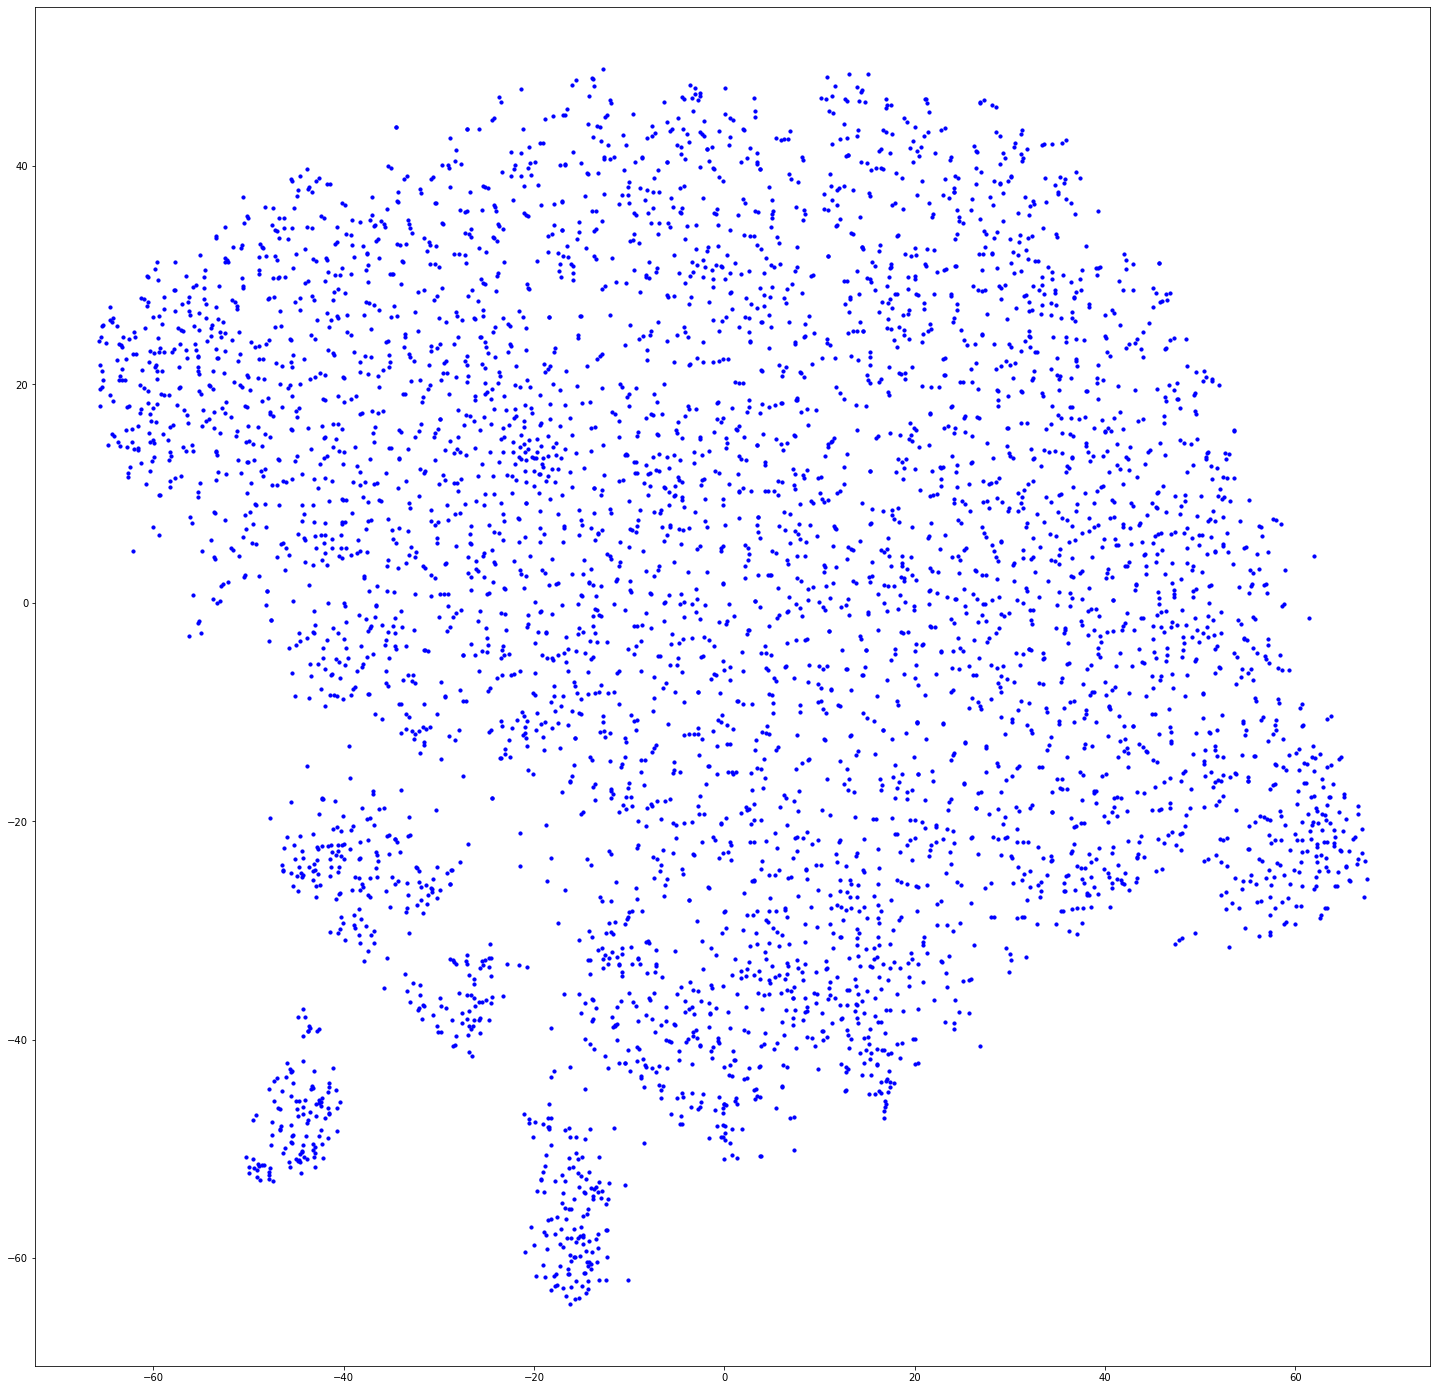

In [156]:
plt.figure(figsize=(25, 25))
plt.scatter([i[0] for i in X_embedded],[i[1] for i in X_embedded],c='blue', s=10)

In [ ]:
for x in range(10):
    plt.hist([i[x] for i in track_vectors], bins = 30)
    plt.show()